In [1]:
# import all revelant packages
from headers import *
outputFolder = 'output'

In [2]:
params = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 100.,
          #'non linear' : 'HMCode',
          #'non linear' : 'halofit',
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'h': 0.6770,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

The experiment has noise $N = 1000 \text{ [Mpc/h]}^3$, which corresponds to $n = 0.001 \text{ [h/Mpc]}^{3}$. I'm evaluating the power spectrum at $z=1$, so I choose to have one redshift bin centered about $1$. I'm setting the bias to $b=1.5$.

In [3]:
exp = experiment(zmin=0.8,zmax=1.2,n=1e-3,nbins=1,sigma_z=0.,b=1.5)

I'm marginalizing over the parameters $\Omega_b, \Omega_c, h, \log(A_s), n_s, b, \text{ and }N$. I'm setting $k_\text{min}=10^{-4}\text{ h/Mpc}$ and $k_\text{max} = 0.2\text{ h/Mpc}$. I'm splitting the integral up into 200 $k$ and $\mu$ bins.

In [4]:
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmax=0.2,Nk=200,Nmu=200)
fishcast.marg_params = np.array(['omega_b','omega_cdm','h','log(A_s)','n_s','b','N'])

To be consistent with Emanuele, I'm setting the volume to be exactly  $22.2 \text{ [Gpc/h]}^3$.

In [5]:
fishcast.Vsurvey = np.array([2.22e10])

In [6]:
F = fishcast.compute_Fisher_matrix()

This is the Fisher matrix that Emanuele gets.

In [7]:
G = np.array([[4.45142819795e8 ,-1.80608721909e8,2.57753702061e7 ,-2.23233666861e7,-3.22526642248e7,-2.52605277442e7,-2988.75624629], 
[-1.80608721909e8,8.06533590801e7 ,-1.28862751558e7,9.44270032084e6 ,1.40800432912e7 ,1.06076456429e7 ,1289.01652831],  
[2.57753702061e7 ,-1.28862751558e7,2.3978617815e6 ,-1.47348867987e6,-2.161143888e6  ,-1.64203066749e6,-190.230007417],
[-2.23233666861e7,9.44270032084e6 ,-1.47348867987e6,1.17339333573e6 ,1.66084756506e6 ,1.32538653921e6 ,151.155238499], 
[-3.22526642248e7,1.40800432912e7 ,-2.161143888e6  ,1.66084756506e6 ,2.49476697721e6 ,1.8747200498e6  ,232.435626086],  
[-2.52605277442e7,1.06076456429e7 ,-1.64203066749e6,1.32538653921e6 ,1.8747200498e6  ,1.52559664834e6 ,176.835856178],  
[-2988.75624629  ,1289.01652831   ,-190.230007417  ,151.155238499   ,232.435626086   ,176.835856178   ,0.0258127871737]])

And here's the ratio of our forecasts.

In [8]:
from tabulate import tabulate
headers = list(fishcast.marg_params.copy())
table = tabulate(G/F,headers)
file = open(outputFolder+'/Fisher_ratio.dat','w')
file.write(table)
file.close()

print(table)

  omega_b    omega_cdm          h    log(A_s)       n_s          b          N
---------  -----------  ---------  ----------  --------  ---------  ---------
 1.22506      1.21022   -0.786449    1.20814    2.67606   1.2177     0.568783
 1.21022      1.18728   -1.04736     1.19263    2.5066    1.20283    0.555021
-0.786449    -1.04736    0.742377   -0.892849  -2.2855   -0.878363  -0.426855
 1.20814      1.19263   -0.892849    1.19033    2.69957   1.19965    0.558486
 2.67606      2.5066    -2.2855      2.69957    4.82452   2.72713    1.13371
 1.2177       1.20283   -0.878363    1.19965    2.72713   1.20824    0.562579
 0.568783     0.555021  -0.426855    0.558486   1.13371   0.562579   0.279757


# Comparing fiducial power spectra at z=0

In [10]:
z=0.
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmin=1.e-5,khmax=40.,Nk=200,Nmu=200)
fishcast.marg_params = np.array(['omega_b','omega_cdm','h','log(A_s)','n_s','b','N'])

In [11]:
data = np.genfromtxt(outputFolder+'/output_.11923_.02247_67.70_matterpower_z000.dat',
                     skip_header=1,
                     skip_footer=1,
                     names=True,
                     dtype=None,
                     delimiter=' ')

In [12]:
EmanK = np.array([data[i][0] for i in range(len(data))])
EmanP = np.array([data[i][3] for i in range(len(data))])

In [13]:
NoahP = np.array([cosmo.pk_lin(k*fishcast.params['h'],z)*fishcast.params['h']**3. for k in EmanK])

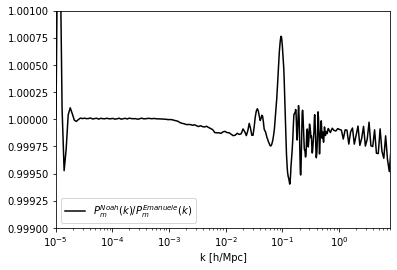

In [14]:
plt.semilogx(EmanK,NoahP/EmanP,label=r'$P^{Noah}_m(k)/P^{Emanuele}_m(k)$',c='k')
plt.xlabel(r'k [h/Mpc]')
plt.legend(loc=0)
plt.xlim(1e-5,8)
plt.ylim(0.999,1.001)
plt.savefig(outputFolder+'/pk_ratio.pdf')

# Derivaties at z=0

In [15]:
from twoPoint import*
z=0.
p_fid = compute_tracer_power_spectrum(fishcast, z)(fishcast.k,fishcast.mu)
d = fishcast.compute_dPdvecp(z,five_point=True)

/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))


In [16]:
data = np.genfromtxt(outputFolder+'/derivatives_dark_matter_z0p0_PlanckBAO.dat')
EmanK = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_cdm = np.array([data[i][2] for i in range(len(data))])
Eman_dPdh = np.array([data[i][3] for i in range(len(data))])
Eman_dPdlogAs = np.array([data[i][4] for i in range(len(data))])
Eman_dPdn_s = np.array([data[i][5] for i in range(len(data))])

In [17]:
p_matter_fid = compute_matter_power_spectrum(fishcast, z)(fishcast.k)
Noah_dPdomega_b = d[0]*p_matter_fid/p_fid
Noah_dPdomega_cdm = d[1]*p_matter_fid/p_fid
Noah_dPdh = d[2]*p_matter_fid/p_fid
Noah_dPdlogAs = d[3]*p_matter_fid/p_fid
Noah_dPdn_s = d[4]*p_matter_fid/p_fid

mu = 0.
Noah_dPdomega_b = fishcast.get_f_at_fixed_mu(Noah_dPdomega_b,mu)(EmanK)
Noah_dPdomega_cdm = fishcast.get_f_at_fixed_mu(Noah_dPdomega_cdm,mu)(EmanK)
Noah_dPdh = fishcast.get_f_at_fixed_mu(Noah_dPdh,mu)(EmanK)
Noah_dPdlogAs = fishcast.get_f_at_fixed_mu(Noah_dPdlogAs,mu)(EmanK)
Noah_dPdn_s = fishcast.get_f_at_fixed_mu(Noah_dPdn_s,mu)(EmanK)

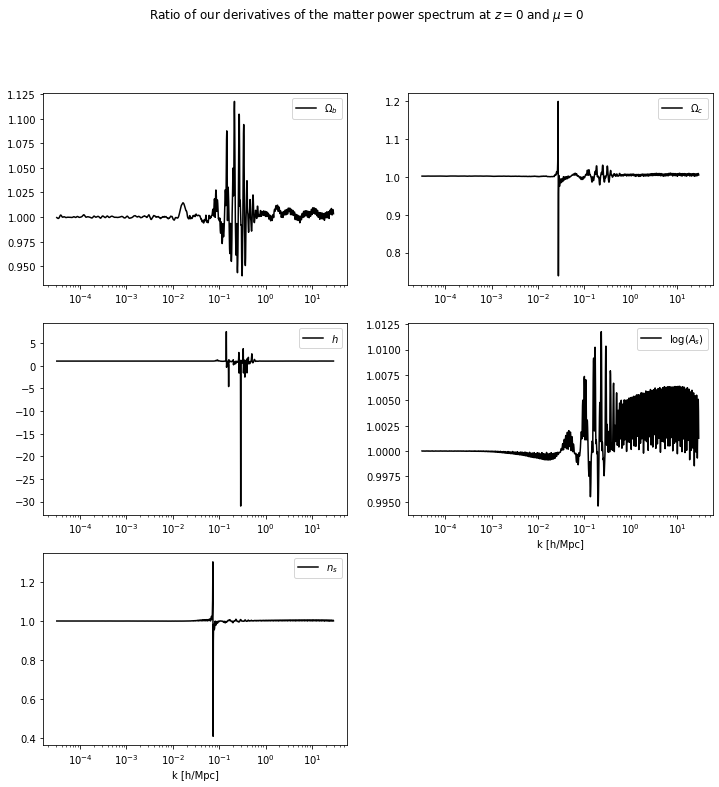

In [18]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
axs[0,0].semilogx(EmanK,Noah_dPdomega_b/Eman_dPdomega_b,c='k',label=r'$\Omega_b$')
axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm/Eman_dPdomega_cdm,c='k',label=r'$\Omega_c$')
axs[1,0].semilogx(EmanK,Noah_dPdh/Eman_dPdh,c='k',label=r'$h$')
axs[1,1].semilogx(EmanK,Noah_dPdlogAs/Eman_dPdlogAs,c='k',label=r'$\log(A_s)$')
axs[2,0].semilogx(EmanK,Noah_dPdn_s/Eman_dPdn_s,c='k',label=r'$n_s$')
axs[0,0].legend(loc=0.)
axs[0,1].legend(loc=0.)
axs[1,0].legend(loc=0.)
axs[1,1].legend(loc=0.)
axs[2,0].legend(loc=0.)

axs[2,0].set_xlabel('k [h/Mpc]')
axs[1,1].set_xlabel('k [h/Mpc]')
axs[2,1].axis('off')

fig.suptitle(r'Ratio of our derivatives of the matter power spectrum at $z=0$ and $\mu=0$')
plt.savefig('output/ratios_matter_power_spectrum_z0.pdf')

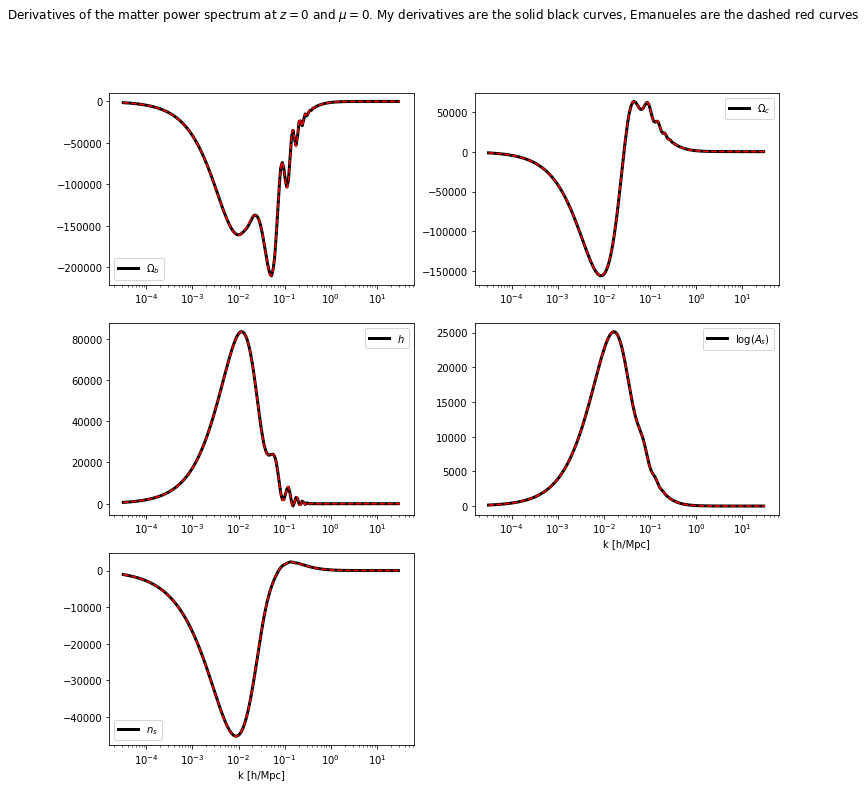

In [19]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
axs[0,0].semilogx(EmanK,Noah_dPdomega_b,c='k',label=r'$\Omega_b$',lw=3.)
axs[0,0].semilogx(EmanK,Eman_dPdomega_b,c='r',ls='--')

axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm,c='k',label=r'$\Omega_c$',lw=3.)
axs[0,1].semilogx(EmanK,Eman_dPdomega_cdm,c='r',ls='--')

axs[1,0].semilogx(EmanK,Noah_dPdh,c='k',label=r'$h$',lw=3.)
axs[1,0].semilogx(EmanK,Eman_dPdh,c='r',ls='--')

axs[1,1].semilogx(EmanK,Noah_dPdlogAs,c='k',label=r'$\log(A_s)$',lw=3.)
axs[1,1].semilogx(EmanK,Eman_dPdlogAs,c='r',ls='--')

axs[2,0].semilogx(EmanK,Noah_dPdn_s,c='k',label=r'$n_s$',lw=3.)
axs[2,0].semilogx(EmanK,Eman_dPdn_s,c='r',ls='--')

axs[0,0].legend(loc=0.)
axs[0,1].legend(loc=0.)
axs[1,0].legend(loc=0.)
axs[1,1].legend(loc=0.)
axs[2,0].legend(loc=0.)

axs[2,0].set_xlabel('k [h/Mpc]')
axs[1,1].set_xlabel('k [h/Mpc]')
axs[2,1].axis('off')

fig.suptitle(r'Derivatives of the matter power spectrum at $z=0$ and $\mu=0$. My derivatives are the solid black curves, Emanuele''s are the dashed red curves')
plt.savefig('output/matter_power_spectrum_z0.pdf')

## "Galaxy" power spectrum at z=1

In [20]:
z=1.
d = fishcast.compute_dPdvecp(z,five_point=True) 

/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))


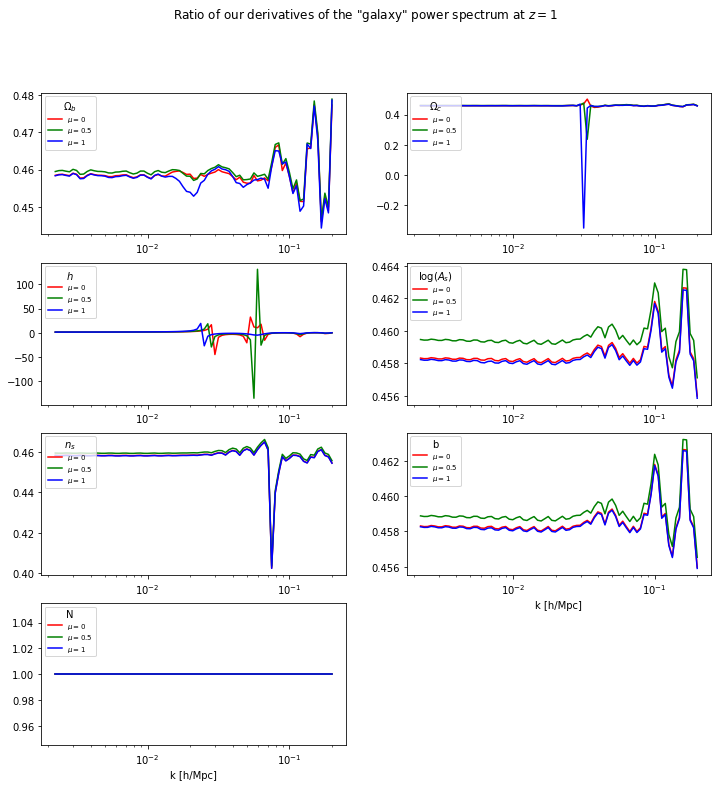

In [21]:
fig, axs = plt.subplots(4, 2,figsize=(12,12))
#
data = np.genfromtxt(outputFolder+'/derivatives_mu0p0_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_cdm = np.array([data[i][2] for i in range(len(data))])
Eman_dPdh = np.array([data[i][3] for i in range(len(data))])
Eman_dPdlogAs = np.array([data[i][4] for i in range(len(data))])
Eman_dPdn_s = np.array([data[i][5] for i in range(len(data))])
Eman_dPdb = np.array([data[i][6] for i in range(len(data))])
Eman_dPdN = np.array([data[i][7] for i in range(len(data))])
mu = 0.
Noah_dPdomega_b = fishcast.get_f_at_fixed_mu(d[0],mu)(EmanK)
Noah_dPdomega_cdm = fishcast.get_f_at_fixed_mu(d[1],mu)(EmanK)
Noah_dPdh = fishcast.get_f_at_fixed_mu(d[2],mu)(EmanK)
Noah_dPdlogAs = fishcast.get_f_at_fixed_mu(d[3],mu)(EmanK)
Noah_dPdn_s = fishcast.get_f_at_fixed_mu(d[4],mu)(EmanK)
Noah_dPdb = fishcast.get_f_at_fixed_mu(d[5],mu)(EmanK)
Noah_dPdN = fishcast.get_f_at_fixed_mu(d[6],mu)(EmanK)
axs[0,0].semilogx(EmanK,Noah_dPdomega_b/Eman_dPdomega_b,c='r',label=r'$\mu=0$')
axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm/Eman_dPdomega_cdm,c='r',label=r'$\mu=0$')
axs[1,0].semilogx(EmanK,Noah_dPdh/Eman_dPdh,c='r',label=r'$\mu=0$')
axs[1,1].semilogx(EmanK,Noah_dPdlogAs/Eman_dPdlogAs,c='r',label=r'$\mu=0$')
axs[2,0].semilogx(EmanK,Noah_dPdn_s/Eman_dPdn_s,c='r',label=r'$\mu=0$')
axs[2,1].semilogx(EmanK,Noah_dPdb/Eman_dPdb,c='r',label=r'$\mu=0$')
axs[3,0].semilogx(EmanK,Noah_dPdN/Eman_dPdN,c='r',label=r'$\mu=0$')
#
data = np.genfromtxt(outputFolder+'/derivatives_mu0p5_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_cdm = np.array([data[i][2] for i in range(len(data))])
Eman_dPdh = np.array([data[i][3] for i in range(len(data))])
Eman_dPdlogAs = np.array([data[i][4] for i in range(len(data))])
Eman_dPdn_s = np.array([data[i][5] for i in range(len(data))])
Eman_dPdb = np.array([data[i][6] for i in range(len(data))])
Eman_dPdN = np.array([data[i][7] for i in range(len(data))])
mu = 0.5
Noah_dPdomega_b = fishcast.get_f_at_fixed_mu(d[0],mu)(EmanK)
Noah_dPdomega_cdm = fishcast.get_f_at_fixed_mu(d[1],mu)(EmanK)
Noah_dPdh = fishcast.get_f_at_fixed_mu(d[2],mu)(EmanK)
Noah_dPdlogAs = fishcast.get_f_at_fixed_mu(d[3],mu)(EmanK)
Noah_dPdn_s = fishcast.get_f_at_fixed_mu(d[4],mu)(EmanK)
Noah_dPdb = fishcast.get_f_at_fixed_mu(d[5],mu)(EmanK)
Noah_dPdN = fishcast.get_f_at_fixed_mu(d[6],mu)(EmanK)
axs[0,0].semilogx(EmanK,Noah_dPdomega_b/Eman_dPdomega_b,c='g',label=r'$\mu=0.5$')
axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm/Eman_dPdomega_cdm,c='g',label=r'$\mu=0.5$')
axs[1,0].semilogx(EmanK,Noah_dPdh/Eman_dPdh,c='g',label=r'$\mu=0.5$')
axs[1,1].semilogx(EmanK,Noah_dPdlogAs/Eman_dPdlogAs,c='g',label=r'$\mu=0.5$')
axs[2,0].semilogx(EmanK,Noah_dPdn_s/Eman_dPdn_s,c='g',label=r'$\mu=0.5$')
axs[2,1].semilogx(EmanK,Noah_dPdb/Eman_dPdb,c='g',label=r'$\mu=0.5$')
axs[3,0].semilogx(EmanK,Noah_dPdN/Eman_dPdN,c='g',label=r'$\mu=0.5$')
#
data = np.genfromtxt(outputFolder+'/derivatives_mu1p0_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_cdm = np.array([data[i][2] for i in range(len(data))])
Eman_dPdh = np.array([data[i][3] for i in range(len(data))])
Eman_dPdlogAs = np.array([data[i][4] for i in range(len(data))])
Eman_dPdn_s = np.array([data[i][5] for i in range(len(data))])
Eman_dPdb = np.array([data[i][6] for i in range(len(data))])
Eman_dPdN = np.array([data[i][7] for i in range(len(data))])
mu = 1.0
Noah_dPdomega_b = fishcast.get_f_at_fixed_mu(d[0],mu)(EmanK)
Noah_dPdomega_cdm = fishcast.get_f_at_fixed_mu(d[1],mu)(EmanK)
Noah_dPdh = fishcast.get_f_at_fixed_mu(d[2],mu)(EmanK)
Noah_dPdlogAs = fishcast.get_f_at_fixed_mu(d[3],mu)(EmanK)
Noah_dPdn_s = fishcast.get_f_at_fixed_mu(d[4],mu)(EmanK)
Noah_dPdb = fishcast.get_f_at_fixed_mu(d[5],mu)(EmanK)
Noah_dPdN = fishcast.get_f_at_fixed_mu(d[6],mu)(EmanK)
axs[0,0].semilogx(EmanK,Noah_dPdomega_b/Eman_dPdomega_b,c='b',label=r'$\mu=1$')
axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm/Eman_dPdomega_cdm,c='b',label=r'$\mu=1$')
axs[1,0].semilogx(EmanK,Noah_dPdh/Eman_dPdh,c='b',label=r'$\mu=1$')
axs[1,1].semilogx(EmanK,Noah_dPdlogAs/Eman_dPdlogAs,c='b',label=r'$\mu=1$')
axs[2,0].semilogx(EmanK,Noah_dPdn_s/Eman_dPdn_s,c='b',label=r'$\mu=1$')
axs[2,1].semilogx(EmanK,Noah_dPdb/Eman_dPdb,c='b',label=r'$\mu=1$')
axs[3,0].semilogx(EmanK,Noah_dPdN/Eman_dPdN,c='b',label=r'$\mu=1$')

axs[0,0].legend(loc=2,title=r'$\Omega_b$',fontsize='x-small', labelspacing=0.2)
axs[0,1].legend(loc=2,title=r'$\Omega_c$',fontsize='x-small', labelspacing=0.2)
axs[1,0].legend(loc=2,title=r'$h$',fontsize='x-small', labelspacing=0.2)
axs[1,1].legend(loc=2,title=r'$\log(A_s)$',fontsize='x-small', labelspacing=0.2)
axs[2,0].legend(loc=2,title=r'$n_s$',fontsize='x-small', labelspacing=0.2)
axs[2,1].legend(loc=2,title=r'b',fontsize='x-small', labelspacing=0.2)
axs[3,0].legend(loc=2,title=r'N',fontsize='x-small', labelspacing=0.2)

axs[3,0].set_xlabel('k [h/Mpc]')
axs[2,1].set_xlabel('k [h/Mpc]')
axs[3,1].axis('off')

fig.suptitle(r'Ratio of our derivatives of the "galaxy" power spectrum at $z=1$')
plt.savefig('output/ratios_galaxy_power_spectrum_z1.pdf')

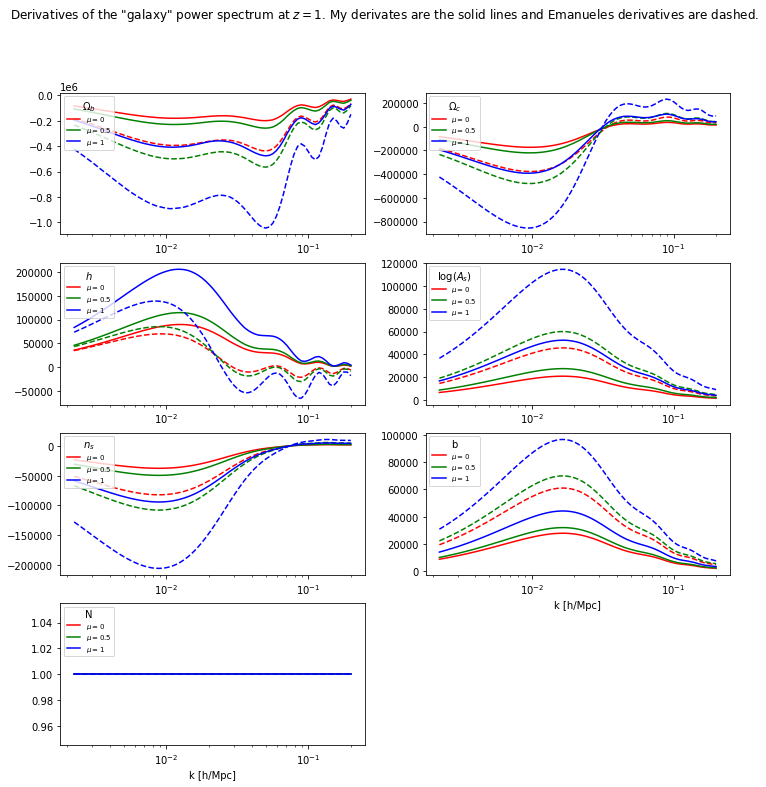

In [24]:
fig, axs = plt.subplots(4, 2,figsize=(12,12))
#
data = np.genfromtxt(outputFolder+'/derivatives_mu0p0_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_cdm = np.array([data[i][2] for i in range(len(data))])
Eman_dPdh = np.array([data[i][3] for i in range(len(data))])
Eman_dPdlogAs = np.array([data[i][4] for i in range(len(data))])
Eman_dPdn_s = np.array([data[i][5] for i in range(len(data))])
Eman_dPdb = np.array([data[i][6] for i in range(len(data))])
Eman_dPdN = np.array([data[i][7] for i in range(len(data))])
mu = 0.
Noah_dPdomega_b = fishcast.get_f_at_fixed_mu(d[0],mu)(EmanK)
Noah_dPdomega_cdm = fishcast.get_f_at_fixed_mu(d[1],mu)(EmanK)
Noah_dPdh = fishcast.get_f_at_fixed_mu(d[2],mu)(EmanK)
Noah_dPdlogAs = fishcast.get_f_at_fixed_mu(d[3],mu)(EmanK)
Noah_dPdn_s = fishcast.get_f_at_fixed_mu(d[4],mu)(EmanK)
Noah_dPdb = fishcast.get_f_at_fixed_mu(d[5],mu)(EmanK)
Noah_dPdN = fishcast.get_f_at_fixed_mu(d[6],mu)(EmanK)

axs[0,0].semilogx(EmanK,Noah_dPdomega_b,c='r',label=r'$\mu=0$')
axs[0,0].semilogx(EmanK,Eman_dPdomega_b,c='r',ls='--')

axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm,c='r',label=r'$\mu=0$')
axs[0,1].semilogx(EmanK,Eman_dPdomega_cdm,c='r',ls='--')

axs[1,0].semilogx(EmanK,Noah_dPdh,c='r',label=r'$\mu=0$')
axs[1,0].semilogx(EmanK,Eman_dPdh,c='r',ls='--')

axs[1,1].semilogx(EmanK,Noah_dPdlogAs,c='r',label=r'$\mu=0$')
axs[1,1].semilogx(EmanK,Eman_dPdlogAs,c='r',ls='--')

axs[2,0].semilogx(EmanK,Noah_dPdn_s,c='r',label=r'$\mu=0$')
axs[2,0].semilogx(EmanK,Eman_dPdn_s,c='r',ls='--')

axs[2,1].semilogx(EmanK,Noah_dPdb,c='r',label=r'$\mu=0$')
axs[2,1].semilogx(EmanK,Eman_dPdb,c='r',ls='--')

axs[3,0].semilogx(EmanK,Noah_dPdN,c='r',label=r'$\mu=0$')
axs[3,0].semilogx(EmanK,Eman_dPdN,c='r',ls='--')
#
data = np.genfromtxt(outputFolder+'/derivatives_mu0p5_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_cdm = np.array([data[i][2] for i in range(len(data))])
Eman_dPdh = np.array([data[i][3] for i in range(len(data))])
Eman_dPdlogAs = np.array([data[i][4] for i in range(len(data))])
Eman_dPdn_s = np.array([data[i][5] for i in range(len(data))])
Eman_dPdb = np.array([data[i][6] for i in range(len(data))])
Eman_dPdN = np.array([data[i][7] for i in range(len(data))])
mu = 0.5
Noah_dPdomega_b = fishcast.get_f_at_fixed_mu(d[0],mu)(EmanK)
Noah_dPdomega_cdm = fishcast.get_f_at_fixed_mu(d[1],mu)(EmanK)
Noah_dPdh = fishcast.get_f_at_fixed_mu(d[2],mu)(EmanK)
Noah_dPdlogAs = fishcast.get_f_at_fixed_mu(d[3],mu)(EmanK)
Noah_dPdn_s = fishcast.get_f_at_fixed_mu(d[4],mu)(EmanK)
Noah_dPdb = fishcast.get_f_at_fixed_mu(d[5],mu)(EmanK)
Noah_dPdN = fishcast.get_f_at_fixed_mu(d[6],mu)(EmanK)

axs[0,0].semilogx(EmanK,Noah_dPdomega_b,c='g',label=r'$\mu=0.5$')
axs[0,0].semilogx(EmanK,Eman_dPdomega_b,c='g',ls='--')

axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm,c='g',label=r'$\mu=0.5$')
axs[0,1].semilogx(EmanK,Eman_dPdomega_cdm,c='g',ls='--')

axs[1,0].semilogx(EmanK,Noah_dPdh,c='g',label=r'$\mu=0.5$')
axs[1,0].semilogx(EmanK,Eman_dPdh,c='g',ls='--')

axs[1,1].semilogx(EmanK,Noah_dPdlogAs,c='g',label=r'$\mu=0.5$')
axs[1,1].semilogx(EmanK,Eman_dPdlogAs,c='g',ls='--')

axs[2,0].semilogx(EmanK,Noah_dPdn_s,c='g',label=r'$\mu=0.5$')
axs[2,0].semilogx(EmanK,Eman_dPdn_s,c='g',ls='--')

axs[2,1].semilogx(EmanK,Noah_dPdb,c='g',label=r'$\mu=0.5$')
axs[2,1].semilogx(EmanK,Eman_dPdb,c='g',ls='--')

axs[3,0].semilogx(EmanK,Noah_dPdN,c='g',label=r'$\mu=0.5$')
axs[3,0].semilogx(EmanK,Eman_dPdN,c='g',ls='--')
#
data = np.genfromtxt(outputFolder+'/derivatives_mu1p0_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_cdm = np.array([data[i][2] for i in range(len(data))])
Eman_dPdh = np.array([data[i][3] for i in range(len(data))])
Eman_dPdlogAs = np.array([data[i][4] for i in range(len(data))])
Eman_dPdn_s = np.array([data[i][5] for i in range(len(data))])
Eman_dPdb = np.array([data[i][6] for i in range(len(data))])
Eman_dPdN = np.array([data[i][7] for i in range(len(data))])
mu = 1.0
Noah_dPdomega_b = fishcast.get_f_at_fixed_mu(d[0],mu)(EmanK)
Noah_dPdomega_cdm = fishcast.get_f_at_fixed_mu(d[1],mu)(EmanK)
Noah_dPdh = fishcast.get_f_at_fixed_mu(d[2],mu)(EmanK)
Noah_dPdlogAs = fishcast.get_f_at_fixed_mu(d[3],mu)(EmanK)
Noah_dPdn_s = fishcast.get_f_at_fixed_mu(d[4],mu)(EmanK)
Noah_dPdb = fishcast.get_f_at_fixed_mu(d[5],mu)(EmanK)
Noah_dPdN = fishcast.get_f_at_fixed_mu(d[6],mu)(EmanK)

axs[0,0].semilogx(EmanK,Noah_dPdomega_b,c='b',label=r'$\mu=1$')
axs[0,0].semilogx(EmanK,Eman_dPdomega_b,c='b',ls='--')

axs[0,1].semilogx(EmanK,Noah_dPdomega_cdm,c='b',label=r'$\mu=1$')
axs[0,1].semilogx(EmanK,Eman_dPdomega_cdm,c='b',ls='--')

axs[1,0].semilogx(EmanK,Noah_dPdh,c='b',label=r'$\mu=1$')
axs[1,0].semilogx(EmanK,Eman_dPdh,c='b',ls='--')

axs[1,1].semilogx(EmanK,Noah_dPdlogAs,c='b',label=r'$\mu=1$')
axs[1,1].semilogx(EmanK,Eman_dPdlogAs,c='b',ls='--')

axs[2,0].semilogx(EmanK,Noah_dPdn_s,c='b',label=r'$\mu=1$')
axs[2,0].semilogx(EmanK,Eman_dPdn_s,c='b',ls='--')

axs[2,1].semilogx(EmanK,Noah_dPdb,c='b',label=r'$\mu=1$')
axs[2,1].semilogx(EmanK,Eman_dPdb,c='b',ls='--')

axs[3,0].semilogx(EmanK,Noah_dPdN,c='b',label=r'$\mu=1$')
axs[3,0].semilogx(EmanK,Eman_dPdN,c='b',ls='--')

axs[0,0].legend(loc=2,title=r'$\Omega_b$',fontsize='x-small', labelspacing=0.2)
axs[0,1].legend(loc=2,title=r'$\Omega_c$',fontsize='x-small', labelspacing=0.2)
axs[1,0].legend(loc=2,title=r'$h$',fontsize='x-small', labelspacing=0.2)
axs[1,1].legend(loc=2,title=r'$\log(A_s)$',fontsize='x-small', labelspacing=0.2)
axs[2,0].legend(loc=2,title=r'$n_s$',fontsize='x-small', labelspacing=0.2)
axs[2,1].legend(loc=2,title=r'b',fontsize='x-small', labelspacing=0.2)
axs[3,0].legend(loc=2,title=r'N',fontsize='x-small', labelspacing=0.2)

axs[3,0].set_xlabel('k [h/Mpc]')
axs[2,1].set_xlabel('k [h/Mpc]')
axs[3,1].axis('off')

fig.suptitle(r'Derivatives of the "galaxy" power spectrum at $z=1$. My derivates are the solid lines and Emanuele''s derivatives are dashed.')
plt.savefig('output/galaxy_power_spectrum_z1.pdf')

/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))
/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))
/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))
/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))
/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))
/home/noah/Documents/Berkeley/fishlss/twoPoint.py:96: RuntimeWarning: invalid value encountered in true_divide
  return lambda k: -(1.+z) * dPdz(k) / (2. * p_fid(k))


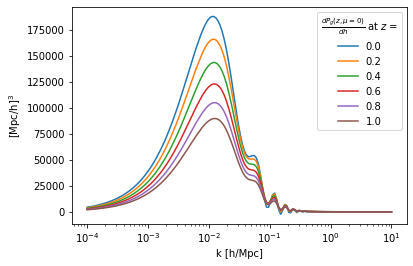

In [53]:
k = np.logspace(-4.,1.,1000)

for z in np.array([0.,0.2,0.4,0.6,0.8,1.0]):
   dPdh = fishcast.compute_dPdp('h',z,five_point=True)
   dPdh = fishcast.get_f_at_fixed_mu(dPdh,.0)
   plt.semilogx(k,dPdh(k),label=str(z))
plt.legend(loc=0,title=r'$\frac{dP_g(z,\mu=0)}{dh}$ at $z=$')
plt.ylabel(r'[Mpc/h]$^3$')
plt.xlabel(r'k [h/Mpc]')
plt.savefig('output/dPdh_vs_z.pdf')